## Tasks
Assigned to Sierra Stevenson, JSIP intern under Dr. Jonathan Jiang and Dr. Longtao Wu

List of Tasks<p>
[DONE]&nbsp;&nbsp;&nbsp;Task 1 — UM moisture at 100 hPa map<br>
[DONE]&nbsp;&nbsp;&nbsp;Task 2 — MLS moisture at 100 hPa map<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 3 — UM/MLS/AIRS vert. profiles moisture vs temp/pressure<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 4 — UM/MLS PDFs (moisture)<br>
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Task 5 — UM/GPM_MERGIR PDFs (brightness temp)

In [23]:
# for logging in:
#    username = smsteven
#    password = 2bhzvjM5YfhV.

## Code
Setup

In [29]:
# NASA Earthdata authorization
from subprocess import Popen
from getpass import getpass
import platform
import os
import shutil

# Data analysis/access
import below_god as bg
import xarray as xr
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [34]:
# Conversion factors
hPa_to_Pa = 100
kgkg_to_ppmv = 1.608 * 10 ** 6
VMR_to_ppmv = 10 ** 6

# Monsoon region coordinates (format: [lon1,lon2,lat1,lat2])
# Asian Monsoon
AM_outercoords = [20, 160,-10,50]
AM_box = [[20,40],[40,140]]

# North American Monsoon
NAM_outercoords = [-140,-40,-10,50]
NAM_box = [[-10,40],[-140,60]]

### MLS data

In [30]:
# Read in MLS hourly data from below_god
# Path and date range
path = "/data/emls/l2gp/v05.01/2016/"
yday_range = np.arange(224,252+1)   # 08/11 - 09/08 (double check)

# Find min length of hourly data
lim = 4000
for day in yday_range:
    # print(day)
    if len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value']) < lim:
        lim = len(bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'])
print(f"The minimum length of 'profile' values in the MLS L2 hourly datasets is {lim}.")

# Initialize xarray with first day
MLS_hrly = bg.io.read_l2gp('/data/emls/l2gp/v05.01/2016/224/MLS-Aura_L2GP-H2O_v05-01-c01_2016d224.he5')['value'][:lim]

# Fill in rest of hourly datasets
for day in yday_range:
    new = bg.io.read_l2gp(f'/data/emls/l2gp/v05.01/2016/{day}/MLS-Aura_L2GP-H2O_v05-01-c01_2016d{day}.he5')['value'][:lim]
    MLS_hrly = xr.concat([MLS_hrly, new], dim='day')

The minimum length of 'profile' values in the MLS L2 hourly datasets is 3402.


MLS hourly data analysis

In [39]:
# Screening: Need to ask Ryan/Longtao

# Select moisture where pressure = 100 hPa and convert to ppmv
MLS_h2o100_hrly = MLS_hrly.sel(lev=100) * VMR_to_ppmv
MLS_h2o100_hrly_arr = np.array(MLS_h2o100_hrly)
MLS_h2o100_hrly_flat = MLS_h2o100_hrly_arr.ravel()

### GPM_MERGIR data

Access GPM Data Archive

In [3]:
urs = 'urs.earthdata.nasa.gov'    # Earthdata URL to call for authentication
prompts = ['Enter NASA Earthdata Login Username \n(or create an account at urs.earthdata.nasa.gov): ',
           'Enter NASA Earthdata Login Password: ']

homeDir = os.path.expanduser("~") + os.sep

with open(homeDir + '.netrc', 'w') as file:
    file.write('machine {} login {} password {}'.format(urs, getpass(prompt=prompts[0]), getpass(prompt=prompts[1])))
    file.close()
with open(homeDir + '.urs_cookies', 'w') as file:
    file.write('')
    file.close()
with open(homeDir + '.dodsrc', 'w') as file:
    file.write('HTTP.COOKIEJAR={}.urs_cookies\n'.format(homeDir))
    file.write('HTTP.NETRC={}.netrc'.format(homeDir))
    file.close()

print('Saved .netrc, .urs_cookies, and .dodsrc to:', homeDir)

# Set appropriate permissions for Linux/macOS
if platform.system() != "Windows":
    Popen('chmod og-rw ~/.netrc', shell=True)
else:
    # Copy dodsrc to working directory in Windows  
    shutil.copy2(homeDir + '.dodsrc', os.getcwd())
    print('Copied .dodsrc to:', os.getcwd())

Saved .netrc, .urs_cookies, and .dodsrc to: /users/smsteven/


Create list of URLS

In [5]:
# Function to create lists of numbers that are all two digit strings (ie '00', '01', '02', ...)
def MakeTwoDigits(arr, num_range):
    for num in num_range:
        if num < 10:
            arr.append("0"+f"{num}")
        else:
            arr.append(f"{num}")

# Create empty arrays
month_vals, yday_range, mday_range, hour_range = [], [], [], []

# Fill arrays and modify as needed
MakeTwoDigits(month_vals, np.int_(np.append(np.ones(21)*8, np.ones(8)*9)))      # Month
MakeTwoDigits(yday_range, np.arange(224,252+1))     # Day of the year
MakeTwoDigits(mday_range, np.arange(1,31+1))        # Day of the month
mday_range = mday_range[10:] + mday_range[0:8]      # Day of the month: Reorder to start from the 11 and end at 08 of the next month
MakeTwoDigits(hour_range, np.arange(0,23+1))        # Hour
day_range = list(zip(yday_range, mday_range, month_vals))   # Map day and month arrays together

# Create list to store .nc files
GPM_data_olr_list = []

# Iterate through OPeNDAP URLs and store each dataset URL in list
for day in day_range:
    for hour in hour_range:
        GPM_data_olr_list.append(f"https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/{day[0]}/merg_2016{day[2]}{day[1]}{hour}_4km-pixel.nc4")

GPM_data_olr_list

['https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081100_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081101_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081102_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081103_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081104_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081105_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081106_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081107_4km-pixel.nc4',
 'https://disc2.gesdisc.eosdis.nasa.gov/opendap/MERGED_IR/GPM_MERGIR.1/2016/224/merg_2016081108_4km-pixe

Read in all data

In [6]:
print("Now uploading data from NASA Earthdata... (Approximately 22 minutes)")
GPM_data = xr.open_mfdataset(GPM_data_olr_list)
print("Upload complete!")
GPM_data

Now uploading data from NASA Earthdata... (Approximately 22 minutes)
Upload complete!


<xarray.Dataset>
Dimensions:  (lon: 9896, lat: 3298, time: 1392)
Coordinates:
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat      (lat) float32 -59.98 -59.95 -59.91 -59.87 ... 59.91 59.95 59.98
  * time     (time) datetime64[ns] 2016-08-11 ... 2016-09-08T23:30:00.000026880
Data variables:
    Tb       (time, lat, lon) float32 dask.array<chunksize=(2, 3298, 9896), meta=np.ndarray>
Attributes:
    BeginDate:       2016-08-11
    BeginTime:       00:00:00.000Z
    EndDate:         2016-08-11
    EndTime:         00:59:59.999Z
    FileHeader:      StartGranuleDateTime=2016-08-11T00:00:00.000Z;\nStopGran...
    InputPointer:    merg_2016081100_4km-pixel
    title:           NCEP/CPC 4km Global (60N - 60S) IR Dataset
    ProductionTime:  2017-11-22T09:04:37.000Z

In [10]:
GPM_OLR = GPM_data['Tb']

In [18]:
GPM_OLR

<xarray.DataArray 'Tb' (time: 1392, lat: 3298, lon: 9896)>
dask.array<concatenate, shape=(1392, 3298, 9896), dtype=float32, chunksize=(2, 3298, 9896), chunktype=numpy.ndarray>
Coordinates:
  * lon      (lon) float32 -180.0 -179.9 -179.9 -179.9 ... 179.9 179.9 180.0
  * lat      (lat) float32 -59.98 -59.95 -59.91 -59.87 ... 59.91 59.95 59.98
  * time     (time) datetime64[ns] 2016-08-11 ... 2016-09-08T23:30:00.000026880
Attributes:
    units:          K
    standard_name:  brightness_temperature

### UM data

UM Moisture

UM OLR (Brightness Temperature)

## Figures

In [16]:
# Labels for plotting
date_range = "08/11/2016 — 09/08/2016"
prs_hPa = 100
AM = "for Asian Monsoon"
NAM = "for North American Monsoon"

# UM
UM_name = "Unified Model"

# MLS
MLS_dates = "08/2004 — 08/2022"
MLS_name = "MLS"

# GPM_MERGIR
GPM_name = "GPM_MERGIR"

# Asian Monsoon [[lat1,lat2],[lon1,lon2]
AM_outercoords = [20, 160,-10,50]
AM_box = [[20,40],[40,140]]

# North American Monsoon
NAM_outercoords = [-140,-40,-10,50]
NAM_box = [[-10,40],[-140,60]]

In [44]:
def CreatePDF(arr, data_label=f"Moisture at {prs_hPa} hPa", source=MLS_name, date_range=date_range, custom_units=None):
    # Plot title
    plt.title(f"{source} Data: Probability Density of {data_label}\nfor {date_range}")

    # Unit labels
    if data_label == f"Moisture at {prs_hPa} hPa":
        units = "ppmv"
    elif data_label == "Brightness Temperature":
        units = "K"
    else:
        units = custom_units

    # x and y labels
    plt.xlabel(data_label + f" ({units})")
    plt.ylabel("Density")

    # Plot PDF
    sns.kdeplot(arr)
    plt.show()

Task 4: UM, MLS moisture PDF at 100hPa (hourly data)

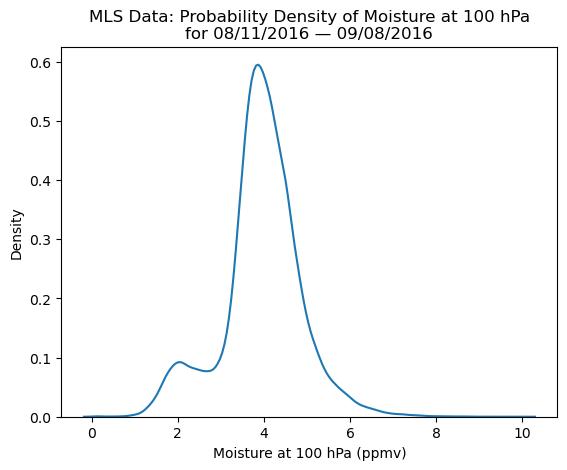

In [45]:
# Global average
# CreatePDF(UM_h2o100_hrly, source=UM_name)
# CreatePDF(MLS_h2o100_hrly_flat)

In [ ]:
# Global average
CreatePDF(UM_h2o100_hrly, source=UM_name)
CreatePDF(MLS_h2o100_hrly)

Task 5: UM, GPM_MERGIR brightness temperature PDF (hourly data)

KeyboardInterrupt: 

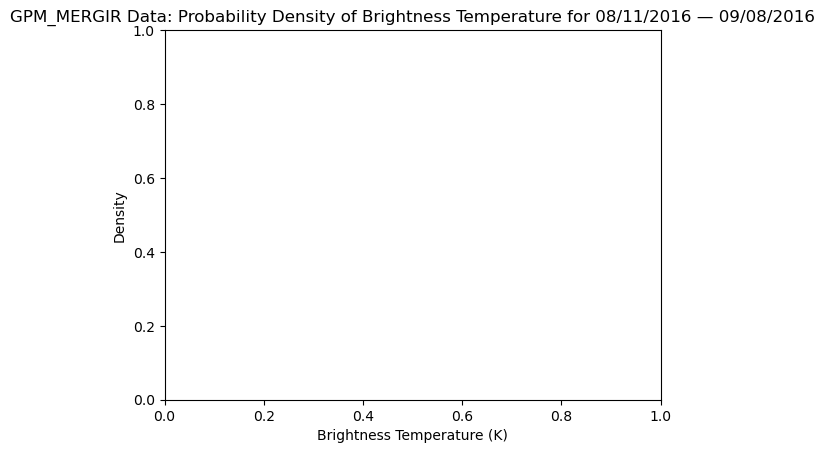

In [ ]:
# CreatePDF(UM_OLR, data_label="Brightness Temperature", source=UM_name)
# CreatePDF(GPM_OLR, data_label="Brightness Temperature", source=GPM_name)